In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [2]:
data_dir = './img/train/'

In [3]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                       #                     [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['cantata_americano', 'cantata_coldbrew', 'cantata_latte', 'colombiana_master', 'colombiana_master_latte', 'gatorade_can', 'pocari_can', 'power_can', 'starbucks_cream', 'starbucks_pike', 'top_latte', 'top_the_black', 'trevi_lime']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 13),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

In [11]:
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #trainer = Trainer(early_stop_callback=True)
        #early_stop_callback = EarlyStopping(
         #   monitor = 'val_accuracy',
         #   #min_delta = 0.00,
         #   patience = 3,
         #   verbose = False,
         #   mode = 'max'
        #)
        #trainer = Trainer(early_stop_callback = early_stop_callback)     
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'new.pth')


Epoch 1/20.. Train loss: 3.422.. Test loss: 2.489.. Test accuracy: 0.306
Epoch 1/20.. Train loss: 1.900.. Test loss: 1.533.. Test accuracy: 0.558
Epoch 1/20.. Train loss: 1.120.. Test loss: 0.794.. Test accuracy: 0.842
Epoch 1/20.. Train loss: 0.709.. Test loss: 0.503.. Test accuracy: 0.872
Epoch 1/20.. Train loss: 0.496.. Test loss: 0.311.. Test accuracy: 0.951
Epoch 1/20.. Train loss: 0.388.. Test loss: 0.240.. Test accuracy: 0.953
Epoch 1/20.. Train loss: 0.267.. Test loss: 0.196.. Test accuracy: 0.952
Epoch 1/20.. Train loss: 0.234.. Test loss: 0.144.. Test accuracy: 0.976
Epoch 1/20.. Train loss: 0.214.. Test loss: 0.124.. Test accuracy: 0.981
Epoch 1/20.. Train loss: 0.213.. Test loss: 0.113.. Test accuracy: 0.972
Epoch 1/20.. Train loss: 0.167.. Test loss: 0.100.. Test accuracy: 0.981
Epoch 1/20.. Train loss: 0.146.. Test loss: 0.083.. Test accuracy: 0.984
Epoch 1/20.. Train loss: 0.147.. Test loss: 0.073.. Test accuracy: 0.987
Epoch 1/20.. Train loss: 0.157.. Test loss: 0.117..

Epoch 7/20.. Train loss: 0.058.. Test loss: 0.023.. Test accuracy: 0.991
Epoch 8/20.. Train loss: 0.038.. Test loss: 0.032.. Test accuracy: 0.989
Epoch 8/20.. Train loss: 0.041.. Test loss: 0.018.. Test accuracy: 0.994
Epoch 8/20.. Train loss: 0.047.. Test loss: 0.012.. Test accuracy: 0.997
Epoch 8/20.. Train loss: 0.041.. Test loss: 0.038.. Test accuracy: 0.986
Epoch 8/20.. Train loss: 0.031.. Test loss: 0.021.. Test accuracy: 0.993
Epoch 8/20.. Train loss: 0.034.. Test loss: 0.014.. Test accuracy: 0.995
Epoch 8/20.. Train loss: 0.025.. Test loss: 0.013.. Test accuracy: 0.997
Epoch 8/20.. Train loss: 0.035.. Test loss: 0.010.. Test accuracy: 0.997
Epoch 8/20.. Train loss: 0.027.. Test loss: 0.016.. Test accuracy: 0.994
Epoch 8/20.. Train loss: 0.018.. Test loss: 0.016.. Test accuracy: 0.995
Epoch 8/20.. Train loss: 0.014.. Test loss: 0.013.. Test accuracy: 0.996
Epoch 8/20.. Train loss: 0.026.. Test loss: 0.013.. Test accuracy: 0.995
Epoch 8/20.. Train loss: 0.040.. Test loss: 0.031..

Epoch 14/20.. Train loss: 0.038.. Test loss: 0.015.. Test accuracy: 0.994
Epoch 14/20.. Train loss: 0.036.. Test loss: 0.011.. Test accuracy: 0.996
Epoch 14/20.. Train loss: 0.044.. Test loss: 0.009.. Test accuracy: 0.997
Epoch 15/20.. Train loss: 0.026.. Test loss: 0.006.. Test accuracy: 0.998
Epoch 15/20.. Train loss: 0.011.. Test loss: 0.006.. Test accuracy: 0.997
Epoch 15/20.. Train loss: 0.015.. Test loss: 0.007.. Test accuracy: 0.997
Epoch 15/20.. Train loss: 0.038.. Test loss: 0.009.. Test accuracy: 0.997
Epoch 15/20.. Train loss: 0.014.. Test loss: 0.011.. Test accuracy: 0.996
Epoch 15/20.. Train loss: 0.016.. Test loss: 0.008.. Test accuracy: 0.998
Epoch 15/20.. Train loss: 0.022.. Test loss: 0.014.. Test accuracy: 0.996
Epoch 15/20.. Train loss: 0.065.. Test loss: 0.016.. Test accuracy: 0.996
Epoch 15/20.. Train loss: 0.043.. Test loss: 0.018.. Test accuracy: 0.994
Epoch 15/20.. Train loss: 0.036.. Test loss: 0.010.. Test accuracy: 0.997
Epoch 15/20.. Train loss: 0.052.. Test

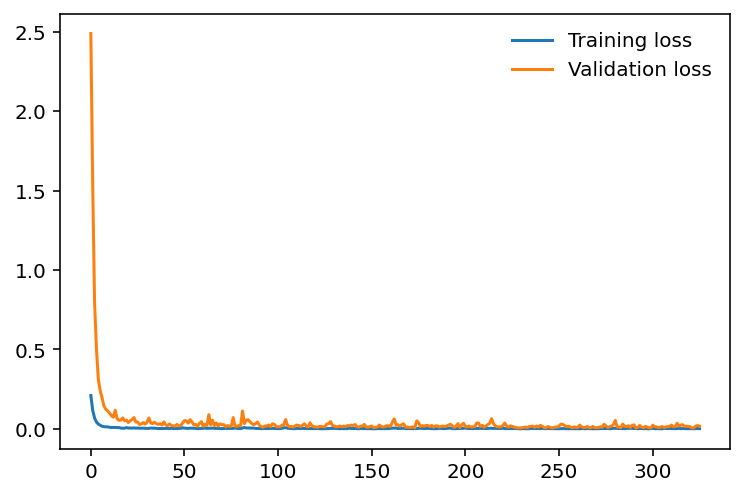

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Inference 

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [14]:
data_dir = './img/train/'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('new.pth')
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index 
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = sorted(os.listdir(data_dir))
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [20]:
classes = sorted(os.listdir(data_dir))

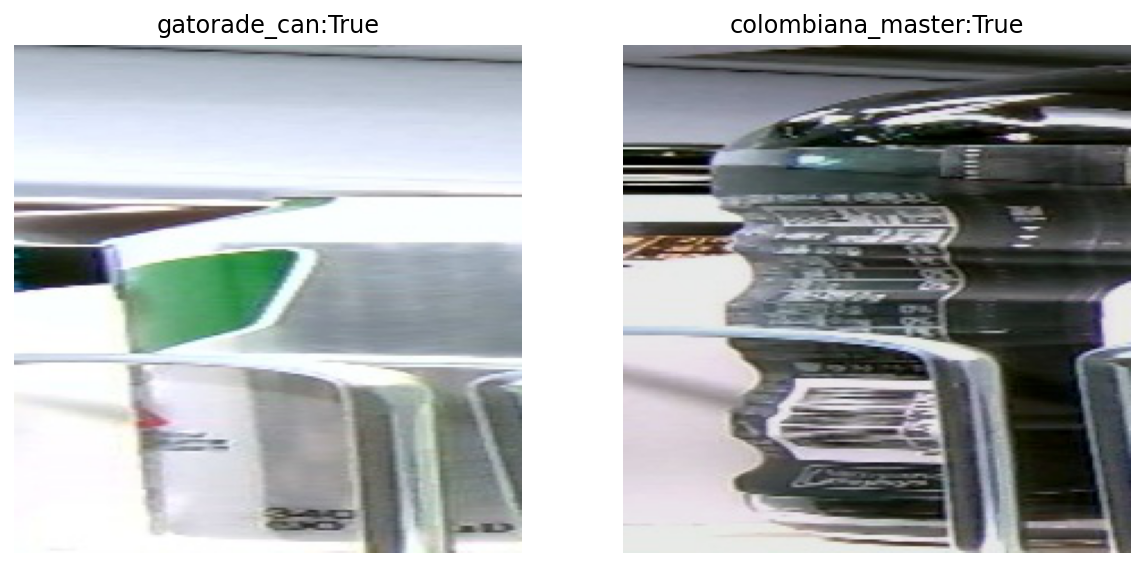

In [23]:
#classes = ['cantata_americano', 'cantata_coldbrew', 'cantata_latte', 'colombiana_master', 'colombiana_master_latte', 'gatorade_can', 'pocari_can', 'power_can', 'starbucks_cream', 'starbucks_pike', 'top_latte', 'top_the_black', 'trevi_lime']
to_pil = transforms.ToPILImage()
images, labels = get_random_images(2)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()
